# `smlb` Tutorial

Scientific Machine Learning Benchmark:<br>
A benchmark of regression models in chem- and materials informatics.<br>
2019-2020, Citrine Informatics.

Import `smlb` and a few standard libraries:

In [1]:
import warnings

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as skl

import smlb

## Introduction

This tutorial showcases basic `smlb` functionality 
by benchmarking different machine learning algorithms
on an experimental materials dataset.
Further examples can be found in the `examples` directory.

We highlight some aspects of `smlb`. See the [Overview](https://github.com/CitrineInformatics/smlb/blob/master/documentation/overview.md) for a description of scope.
    
1. *Interfaces*. `smlb` defines interfaces (classes) for machine-learning concepts, such as labeled datasets, algorithms for regression, sampling, evaluation metrics and others. This supports correct benchmarking and enables flexibility when combining specific instances (datasets, algorithms, ...) of these concepts from different sources.
2. *Instances*. `smlb` comes with several benchmarking datasets and wrappers for machine-learning algorithms included\, for example from [scikit-learn](https://scikit-learn.org/) and [Chemistry Development Kit](https://cdk.github.io/). Adding new datasets and algorithms is easy.
3. *Functionality*. `smlb` provides tailored functionality for its purpose, for example, features for molecules and materials, evaluation metrics for predictive uncertainties, or learning curve plots.

In the following, we will benchmark several random forest variants for predicting the band gap of a set of elemental and binary semiconductors and insulators from the literature.

## Dataset

First, we load the dataset from the `dataset` directory where the pre-packaged datasets from `smlb` reside. 
Use tab completion for easy selection.

In [1]:
from datasets.experimental.band_gaps_sc73.band_gaps_sc73 import BandGapsStrehlowCook1973Dataset

The `BandGapsStrehlowCook1973Dataset` dataset is an instance of the `Data` interface.
Specifically it derives from `IndexedFiniteData` and `IndexedFiniteLabels`. 

For information on the dataset and how to use it, 
print the doc-strings of the class and the initializer:

In [2]:
print(BandGapsStrehlowCook1973Dataset.__doc__)
print(BandGapsStrehlowCook1973Dataset.__init__.__doc__)

Band gaps from Strehlow & Cook (1973) dataset.

    Based on:
    W. H. Strehlow, E. L. Cook: Compilation of Energy Band Gaps in Elemental and Binary
    Compound Semiconductors and Insulators, Journal of Physical Chemistry Reference Data
    2(1): 163-199, American Institute of Physics, 1973. DOI 10.1063/1.3253115

    Curated version downloaded from the Citrination platform (https://citrination.com),
    dataset identifier #1160, on 2019-07-17.

    This dataset provides 1,459 compounds, 1,447 of them with measured band gap (eV).
    Compound information includes chemical sum formula and, where specified, measurement
    temperature (K), crystallinity of sample (amorphous, single, or poly-crystalline)
    and other properties.
    
Loads dataset.

        Parameters control preprocessing.

        Parameters:
            filter_: function that accepts a sample and returns whether to keep it (True)
                     or to exclude it (False). 
                     Possible choices:


We must avoid the same material showing up multiple times in the dataset,
and thus potentially appearing in both training and validation set, 
as this would cause arbitrarily over-optimistic performance estimates.
Note that formulas like $\text{Mg}_3\text{As}_2$ and $\text{Mg}_{1.5}\text{As}_1$ describe the same compound; `smlb` takes this into account.

Overlap between training and validation sets is a frequent mistake;
`smlb` supports correctness by providing an option to `join` entries
with the same sum formula upon loading the dataset. 
We use this and assign the median band gap as label.
Since we will use only the formula as input we extract only those:

In [4]:
data = BandGapsStrehlowCook1973Dataset(filter_='bg', join=1, samplef=lambda e: e['formula'], labelf=np.median)
print(data.num_samples, 'entries in total')
print(data.samples()[-10])  # example entry

495 entries in total
Sb0.09Bi0.91


The entries of the dataset are sum formulas encoded as strings.
`smlb` supports non-numeric inputs, such as strings or graphs.

From 1,447 samples, 495 were unique (34%). 
On average, each compound is contained 3 times in the dataset.
However, the actual distribution is asymmetric, most compounds only have a single measurement:

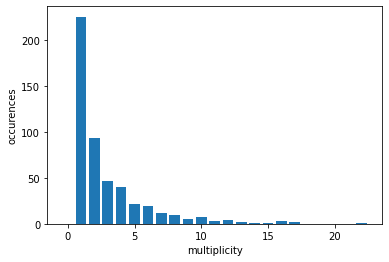

In [5]:
t = BandGapsStrehlowCook1973Dataset(filter_='bg', join=False, samplef=lambda e: e['formula'])
_, counts = np.unique(t.samples(), return_counts=True)
counts = np.bincount(counts[::-1])  # [::-1] gives reverse view
plt.bar(np.arange(0, len(counts), 1), counts)
plt.xlabel("multiplicity"); plt.ylabel("occurences")
plt.show()
del t, _, counts

## Features

While `smlb` is happy to work on strings, 
the regression algorithms we will use are not.
We therefore need to create numerical features from the sum formulas.

For this, `smlb` provides `Features`, a `DataValuedTransformation`.
We will use the "magpie" features of [matminer](https://hackingmaterials.lbl.gov/matminer/).
Tab completion also works here.

In [3]:
from features.matminer_composition import MatminerCompositionFeatures

In [4]:
print(MatminerCompositionFeatures.__doc__)

Matminer composition-based materials features.

    Based on the matminer package.

    Reference:
        Logan Ward, Alexander Dunn, Alireza Faghaninia, Nils E.R. Zimmermann, Saurabh Bajaj,
        Qi Wang., Joseph Montoya, Jiming Chen, Kyle Bystrom, Maxwell Dylla, Kyle Chard,
        Mark Asta, Kristin A. Persson, G. Jeffrey Snyder, Ian Foster, Anubhav Jain:
        Matminer: An open source toolkit for materials data mining, Computational Materials
        Science 152: 60--69, Elsevier, 2018. DOI 10.1016/j.commatsci.2018.05.018

    Code and documentation:
        https://hackingmaterials.lbl.gov/matminer/
        https://github.com/hackingmaterials/matminer

    Currently supports four types of features:
    * Stoichiometric attributes describe the amount of each element present in
      a compound using several L^p norms.
    * Elemental property statistics, computed on 22 different elemental
      properties, such as distribution of atomic radii.
    * Ionic compound attributes, 

In `smlb`, we will normally not explicitly compute the features ourselves.
Instead, we just instantiate the featurizer object for later use in a `Workflow`.

In [5]:
with warnings.catch_warnings():  # prevent warning about deprecated NumPy feature
    warnings.simplefilter("ignore", category=FutureWarning)
    features = MatminerCompositionFeatures(ionic_fast=True)

`Features` are `DataValuedTransformations`, which means that they accept `Data` as input and produce other `Data` as output.
Let us featurize the band gap dataset just to take a look at one of the resulting feature vectors:

[  2.     0.91   0.91   0.91   0.91   0.91  51.    83.    32.    80.12
   5.24  83.    85.    86.     1.    85.91   0.16  86.   121.76 208.98
  87.22 201.13  14.29 208.98 544.4  903.78 359.38 576.74  58.87 544.4
  15.    15.     0.    15.     0.    15.     5.     6.     1.     5.91
   0.16   6.   139.   148.     9.   147.19   1.47 148.     2.02   2.05
   0.03   2.02   0.     2.02   2.     2.     0.     2.     0.     2.
   3.     3.     0.     3.     0.     3.    10.    10.     0.    10.
   0.    10.     0.    14.    14.    12.74   2.29  14.    15.    29.
  14.    27.74   2.29  29.     0.     0.     0.     0.     0.     0.
   3.     3.     0.     3.     0.     3.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     3.     3.
   0.     3.     0.     3.    31.56  32.95   1.39  32.82   0.23  32.95
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.    12.   166.   154.    25.86  25.23  12.     0.     0.
   0.     2.     3.    

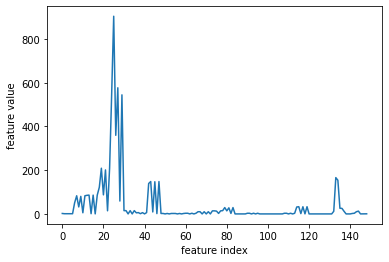

In [12]:
t = features.fit(data).apply(data).samples()[-10]  # 9% Sb 91% Bi example from above

with np.printoptions(precision=2, suppress=True):
    print(t)

plt.plot(t)
plt.xlabel('feature index'); plt.ylabel('feature value')
plt.show()

del t

## Machine-learning algorithms

We compare three variants of random forest regression from the scientific community's `scikit-learn` project and the open-source `lolo` library.
`smlb` wraps all of those already. 
Again, tab completion provides an overview of existing learners.
Note that using the `lolo` learner requires the `lolo` dependency.

In [13]:
from learners.scikit_learn.random_forest_regression_sklearn import RandomForestRegressionSklearn
from learners.scikit_learn.extremely_randomized_trees_regression_sklearn import ExtremelyRandomizedTreesRegressionSklearn
from learners.scikit_learn.gradient_boosted_trees_regression_sklearn import GradientBoostedTreesRegressionSklearn

from learners.lolo.random_forest_regression_lolo import RandomForestRegressionLolo

Each of these learners derives from `Learner`, specifically `SupervisedLearner`.
`Learner`s are special cases of `DataTransformation`s.
They have a `fit` method for training the model and an `apply` method to predict new data.
Predictions always take the form of `PredictiveDistribution`s. 
Implementations that return only point predictions yield a `DeltaPredictiveDistribution`.

`Learner`s can be parametrized at runtime. 
Here, we use default values.
Specifying seeds for pseudo-random number generation is *mandatory*.

<div class="alert alert-block alert-info">
    <b><tt>smlb</tt> and pseudo-random numbers</b><br>
    "Random" numbers are generated deterministically using <a href="https://en.wikipedia.org/wiki/Random_number_generation">pseudo-random number generators</a> (PRNG).
    <tt>smlb</tt> takes reproducibility seriously:
    Given identical software and hardware, results will be deterministic for a given seed, even if running asynchronously, in parallel, or in a distributed environment.
    This supports reproducibility; as a consequence, PRNG seeds must be specified.
    For this, <tt>smlb</tt> uses ideas from the <a href="https://github.com/google/jax/blob/master/design_notes/prng.md">Google JAX PRNG design</a>.
</div>

In [14]:
prng = smlb.Random(rng=42)  # master seed

In [15]:
rng_seeds = prng.random.split(4)
rf_skl = RandomForestRegressionSklearn(random_state=rng_seeds[0])
ert_skl = ExtremelyRandomizedTreesRegressionSklearn(random_state=rng_seeds[1])
gbt_skl = GradientBoostedTreesRegressionSklearn(random_state=rng_seeds[2])
rf_lolo = RandomForestRegressionLolo()  # unfortunately, lolo does not support this yet; issue #206

## Sampling

We split the dataset into a validation set and training sets of increasing size.
By keeping the validation set fixed, we avoid additional randomness between training set sizes due to the choice of validation set.

In `smlb`, we do not draw these sets ourselves.
Instead, we define `Sampler`s and pass those to a `Workflow` (next section).

We choose the training set sizes to be equi-distant in log-space.
The validation set must be large enough for sufficient error statistics,
and small enough to leave enough samples for training.
With 495 samples, this dataset is in a border region where both
cross-validation and hold-out sets are feasible.

In [16]:
nvalid = int(495*0.2)  # 20% hold-out set
ntrain_min, ntrain_max, k = 10, 495-nvalid, 6  # k = number of training set sizes
ntrain = np.logspace(np.log10(ntrain_min), np.log10(ntrain_max), k, dtype=int)
print(ntrain)

[ 10  20  43  90 189 395]


In [17]:
smpl_seeds = prng.random.split(k+1)
smpl_valid = smlb.RandomSubsetSampler(size=nvalid, rng=smpl_seeds[0])
smpl_train = tuple(smlb.RandomSubsetSampler(size=ntrain[i], rng=smpl_seeds[i+1]) for i in range(k))

## Workflow

It's time to put everything together!
`Workflow`s are pre-defined algorithms for benchmarking.

We use a simple `Workflow` to compare different algorithms on a single dataset.
Again, use tab completion to select from existing `Workflow`s

In [18]:
from workflows.learning_curve_regression import LearningCurveRegression

In [19]:
print(LearningCurveRegression.__doc__)
print(LearningCurveRegression.__init__.__doc__)

Learning-curve for multiple regression learners on a single dataset.

    Algorithm:
    1) Validation data
       Draw validation data from dataset
       For finite datasets, remove validation data from dataset
    2) Training sets
       Draw training sets from remaining dataset
       Validate that there is no overlap with the validation set
    3) Featurization
       Featurize validation and training sets
    4) Training and prediction
       Train each learner on each training set
       For each trained learner, predict validation set
    5) Evaluate results
       Compute evaluation metric for each run
       Render each evaluation

    Current limitations:
    * no hyperparameter optimization
    * no repeated sampling
    
Initialize workflow.

        Parameters:
            data: labeled data
            training: sequence of Samplers, one for each training set size
            validation: Sampler for validation set
            learners: sequence of supervised regression a

Because we want to view the resulting plot directly in the notebook
(as opposed to saving it to a file), we create a matplotlib figure
and let the `LearningCurvePlot` render to it.

The `Workflow` itself executes when we run it, 
and should take less than a minute to complete.

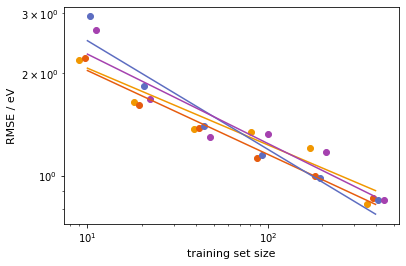

In [20]:
fig, ax = plt.subplots()
lcplot = smlb.LearningCurvePlot(target=ax, rectify=True)

wf = LearningCurveRegression(
    data=data, training=smpl_train, validation=smpl_valid,
    learners=[rf_skl, ert_skl, gbt_skl, rf_lolo],
    features=features,
    # default evaluation metric is smlb.RootMeanSquaredError
    evaluations=[lcplot]
)

wf.run()

ax.set_ylabel('RMSE / eV')
plt.show()

In this figure, `smlb` has shifted the plotted prediction errors for each training set size a little bit to the left and right (`rectify=True`) for better readability (otherwise, all points for a given training set size would sit on top of each other). 

The straight lines are fits of the learning-theoretical decay of the prediction errors to the observed values. The behaviour of all algorithms is in reasonable agreement with theory, especially given the small training set sizes.

Overall, all random forest variants exhibit similar performance on this dataset.
The observed RMSE is $\approx$ 0.85 eV for 395 training samples, which corresponds to 7% of the $\approx$ 12.3 eV range of band gaps in this dataset.
We conclude that

1. `lolo` random forest implementation is on par with the ones from `scikit-learn`
2. Experimentally determined band gaps are predicted well, with RMSE between 2 eV and 0.85 eV depending on amount of training data